In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np


In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    print("Name:", gpu.name, "  Type:", gpu.device_type)

tf.test.is_gpu_available()

strategy = tf.distribute.experimental.MultiWorkerMirroredStrategy()
print("Number of accelerators: ", strategy.num_replicas_in_sync)
batch_size = 32 * strategy.num_replicas_in_sync


Name: /physical_device:GPU:0   Type: GPU
Name: /physical_device:GPU:1   Type: GPU
Number of accelerators:  2


In [3]:
# # NEW on TPU in TensorFlow 24: shorter cross-compatible TPU/GPU/multi-GPU/cluster-GPU detection code

# try: # detect TPUs
#     tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect() # TPU detection
#     strategy = tf.distribute.TPUStrategy(tpu)
# except ValueError: # detect GPUs
#     strategy = tf.distribute.MirroredStrategy() # for GPU or multi-GPU machines
#     #strategy = tf.distribute.get_strategy() # default strategy that works on CPU and single GPU
#     strategy = tf.distribute.experimental.MultiWorkerMirroredStrategy() # for clusters of multi-GPU machines

# print("Number of accelerators: ", strategy.num_replicas_in_sync)
# batch_size = 32 * strategy.num_replicas_in_sync


In [4]:
from itertools import chain

In [5]:
aug_gen =  tf.keras.preprocessing.image.ImageDataGenerator(shear_range=0.2,zoom_range=0.2,rotation_range=20,horizontal_flip=True,fill_mode='constant',width_shift_range=0.2,  
            height_shift_range=0.2)
aug_dataset = aug_gen.flow_from_directory(
    '/kaggle/input/rice-dataset-2/Extracted_dataset-2/train',
    target_size=(224,224),
    color_mode='rgb',
    classes=None,
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=True,
    seed=1,
    interpolation='nearest',
    keep_aspect_ratio=False
)
train_gen =  tf.keras.preprocessing.image.ImageDataGenerator()
train_dataset=train_gen.flow_from_directory(
    '/kaggle/input/rice-dataset-2/Extracted_dataset-2/train',
    target_size=(224,224),
    color_mode='rgb',
    classes=None,
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=True,
    seed=10,
    interpolation='nearest',
    keep_aspect_ratio=False
)

val_gen = tf.keras.preprocessing.image.ImageDataGenerator()
val_dataset = val_gen.flow_from_directory(
    '/kaggle/input/rice-dataset-2/Extracted_dataset-2/test',
    target_size=(224,224),
    color_mode='rgb',
    classes=None,
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=True,
    seed=1,
    interpolation='nearest',
    keep_aspect_ratio=False
)



Found 2878 images belonging to 9 classes.
Found 2878 images belonging to 9 classes.
Found 717 images belonging to 9 classes.


In [6]:
# train_dataset
dataset = chain(train_dataset,aug_dataset)
# np.shape(dataset)

In [7]:
steps_per_epoch =(2*12672)//batch_size
validation_steps = 1227//batch_size

In [8]:
with strategy.scope():
    def f1_metric(y_true,y_pred):
        tp = tf.reduce_sum(y_true * tf.round(y_pred), axis=0)
        fp = tf.reduce_sum(tf.round(y_pred) - y_true, axis=0)
        fn = tf.reduce_sum(y_true - tf.round(y_pred), axis=0)

        precision = tp / (tp + fp + tf.keras.backend.epsilon())
        recall = tp / (tp + fn + tf.keras.backend.epsilon())

        f1 = 2 * precision * recall / (precision + recall + tf.keras.backend.epsilon())
        macro_f1 = tf.reduce_mean(f1)
        return macro_f1
    def model():
        pre = tf.keras.applications.mobilenet.MobileNet(include_top=False,weights='imagenet',input_shape=(224,224,3))
        pre.trainable=True
        
        inputs = tf.keras.Input(shape=(224,224,3),name='input')
        X = tf.keras.applications.mobilenet.preprocess_input(inputs)
        X = pre(X)
       
        X = tf.keras.layers.GlobalMaxPooling2D()(X)
        outputs = tf.keras.layers.Dense(units=9,activation='softmax')(X)
        model = tf.keras.Model(inputs, outputs)
        model.summary()
        return model

    conv_model = model()
    conv_model.compile(optimizer = tf.keras.optimizers.Adam(), loss = tf.keras.losses.CategoricalCrossentropy(), metrics=['accuracy',f1_metric])

17225924/17225924 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 mobilenet_1.00_224 (Functio  (None, 7, 7, 1024)       3228864   
 nal)                                                            
                                                                 
 global_max_pooling2d (Globa  (None, 1024)             0      

In [9]:

history = conv_model.fit(dataset, validation_data =val_dataset, steps_per_epoch=steps_per_epoch,validation_steps=validation_steps,epochs=31, verbose=1,callbacks=[tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',factor=0.9,patience=3, verbose=1,min_delta=0.0001,min_lr=0.000001),tf.keras.callbacks.EarlyStopping(monitor="val_loss",patience=10,verbose=1, mode="auto",restore_best_weights=True)])

Epoch 1/31
396/396 [==============================] - 1327s 3s/step - loss: 0.4494 - accuracy: 0.9009 - f1_metric: 0.9505 - val_loss: 0.5147 - val_accuracy: 0.8982 - val_f1_metric: 0.9167 - lr: 0.0010
Epoch 2/31
396/396 [==============================] - 1207s 3s/step - loss: 0.1073 - accuracy: 0.9760 - f1_metric: 0.9735 - lr: 0.0010
Epoch 3/31
396/396 [==============================] - 1230s 3s/step - loss: 0.1147 - accuracy: 0.9776 - f1_metric: 0.9677 - lr: 0.0010
Epoch 4/31
396/396 [==============================] - 1230s 3s/step - loss: 0.1091 - accuracy: 0.9804 - f1_metric: 0.9711 - lr: 0.0010
Epoch 5/31
396/396 [==============================] - 1238s 3s/step - loss: 0.0927 - accuracy: 0.9841 - f1_metric: 0.9712 - lr: 0.0010
Epoch 6/31
396/396 [==============================] - 1246s 3s/step - loss: 0.0707 - accuracy: 0.9879 - f1_metric: 0.9731 - lr: 0.0010
Epoch 7/31
396/396 [==============================] - 1244s 3s/step - loss: 0.1067 - accuracy: 0.9835 - f1_metric: 0.9731 - 

In [10]:
model_json = conv_model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

conv_model.save_weights("RC.h5")

In [11]:
converter = tf.lite.TFLiteConverter.from_keras_model(conv_model)
tflite_model = converter.convert()

with open('model.tflite','wb') as f:
    f.write(tflite_model)

In [12]:
conv_model.evaluate(val_dataset)

12/12 [==============================] - 31s 3s/step - loss: 6.2637 - accuracy: 0.7587 - f1_metric: 0.8194


[6.263697624206543, 0.758716881275177, 0.819444477558136]

### Class Activation Maps

In [13]:
inputs = tf.keras.Input(shape=(224,224,3),name='input')
X = tf.keras.applications.mobilenet.preprocess_input(inputs)
outs = conv_model.layers[-3](X)
X = conv_model.layers[-2](outs)
outs2 = conv_model.layers[-1](X)
model = tf.keras.Model(inputs=inputs,outputs=(outs,outs2))

import scipy as sp
j=next(train_dataset)
o1, o2 =model(j[0])
images = j[0]

Shath Blight


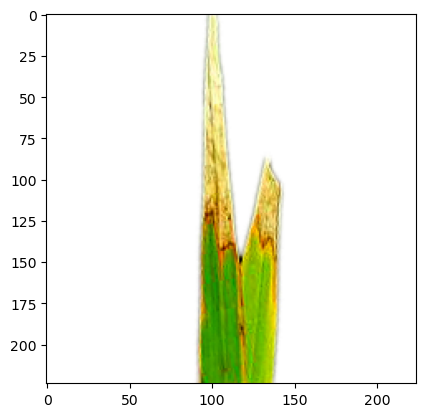

In [14]:
idx =1
features_for_img = o1[idx,:,:,:]
cat = tf.argmax(o2[idx]).numpy()
weights = model.layers[-1].get_weights()[0][:,cat]
image = sp.ndimage.zoom(features_for_img, (32,32,1), order=1)
k=np.dot(image[:,:,:],weights)
p=tf.keras.applications.mobilenet.preprocess_input(images)
dict1={0:'bacterial_leaf_blight',1:'Brown_Spot',2:'Healthy',3:'Hispa',4:'leaf_blast',5:'leaf_scald',6:'narrow_brown_spot',7:'Shath Blight',8:'Tungro'}
print(dict1[cat])
plt.imshow(images[idx,:,:,:])
plt.show()

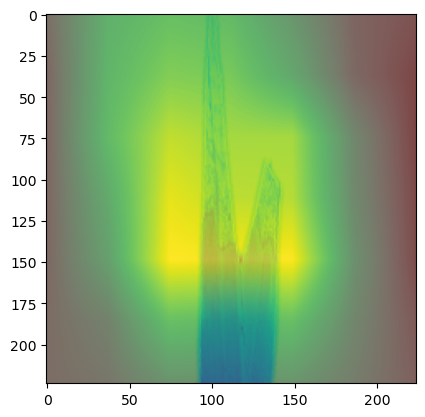

In [15]:
plt.imshow(np.mean(p[idx,:,:],axis=-1))
plt.imshow(k,alpha=0.7)
plt.show()

bacterial_leaf_blight


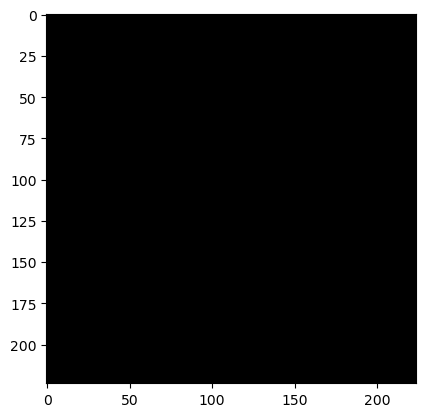

In [16]:
idx =2
features_for_img = o1[idx,:,:,:]
cat = tf.argmax(o2[idx]).numpy()
weights = model.layers[-1].get_weights()[0][:,cat]
image = sp.ndimage.zoom(features_for_img, (32,32,1), order=1)
k=np.dot(image[:,:,:],weights)
p=tf.keras.applications.mobilenet.preprocess_input(images)
dict1={0:'bacterial_leaf_blight',1:'Brown_Spot',2:'Healthy',3:'Hispa',4:'leaf_blast',5:'leaf_scald',6:'narrow_brown_spot',7:'Shath Blight',8:'Tungro'}
print(dict1[cat])
plt.imshow(images[idx,:,:,:])
plt.show()

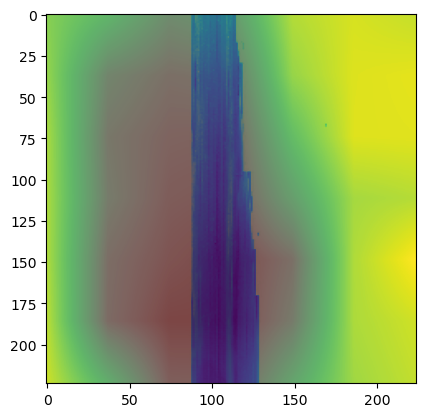

In [17]:
plt.imshow(np.mean(p[idx,:,:],axis=-1))
plt.imshow(k,alpha=0.7)
plt.show()

narrow_brown_spot


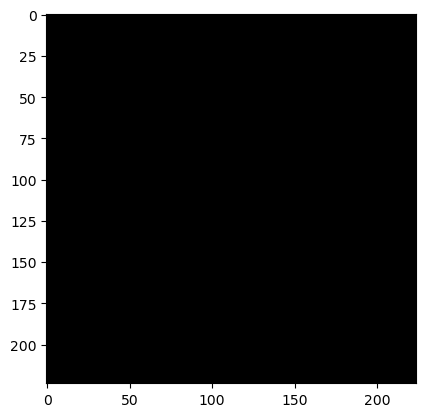

In [18]:
idx =3
features_for_img = o1[idx,:,:,:]
cat = tf.argmax(o2[idx]).numpy()
weights = model.layers[-1].get_weights()[0][:,cat]
image = sp.ndimage.zoom(features_for_img, (32,32,1), order=1)
k=np.dot(image[:,:,:],weights)
p=tf.keras.applications.mobilenet.preprocess_input(images)
dict1={0:'bacterial_leaf_blight',1:'Brown_Spot',2:'Healthy',3:'Hispa',4:'leaf_blast',5:'leaf_scald',6:'narrow_brown_spot',7:'Shath Blight',8:'Tungro'}
print(dict1[cat])
plt.imshow(images[idx,:,:,:])
plt.show()

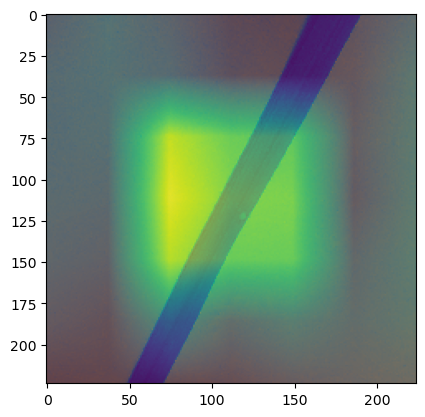

In [19]:
plt.imshow(np.mean(p[idx,:,:],axis=-1))
plt.imshow(k,alpha=0.7)
plt.show()

bacterial_leaf_blight


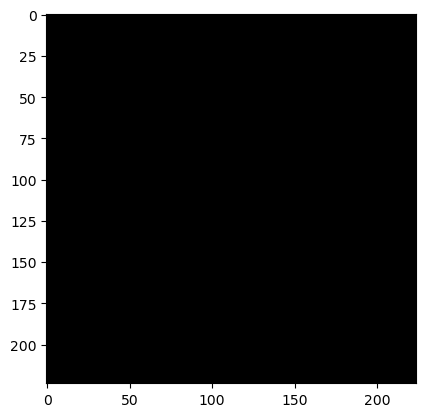

In [20]:
idx =4
features_for_img = o1[idx,:,:,:]
cat = tf.argmax(o2[idx]).numpy()
weights = model.layers[-1].get_weights()[0][:,cat]
image = sp.ndimage.zoom(features_for_img, (32,32,1), order=1)
k=np.dot(image[:,:,:],weights)
p=tf.keras.applications.mobilenet.preprocess_input(images)
dict1={0:'bacterial_leaf_blight',1:'Brown_Spot',2:'Healthy',3:'Hispa',4:'leaf_blast',5:'leaf_scald',6:'narrow_brown_spot',7:'Shath Blight',8:'Tungro'}
print(dict1[cat])
plt.imshow(images[idx,:,:,:])
plt.show()

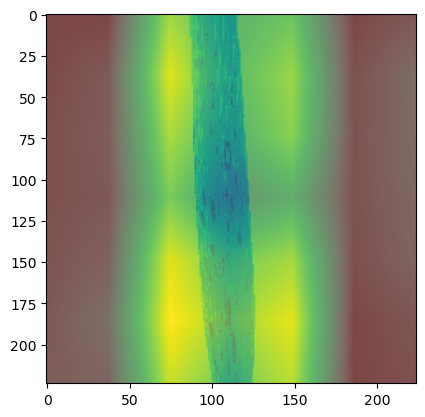

In [21]:
plt.imshow(np.mean(p[idx,:,:],axis=-1))
plt.imshow(k,alpha=0.7)
plt.show()

bacterial_leaf_blight


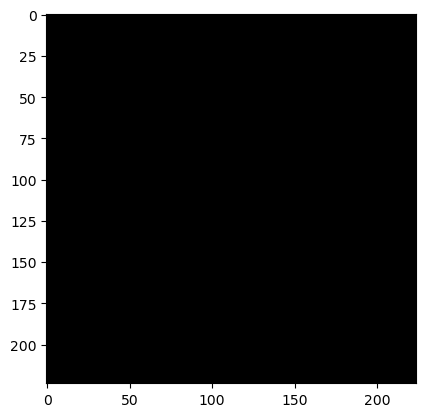

In [22]:
idx =5
features_for_img = o1[idx,:,:,:]
cat = tf.argmax(o2[idx]).numpy()
weights = model.layers[-1].get_weights()[0][:,cat]
image = sp.ndimage.zoom(features_for_img, (32,32,1), order=1)
k=np.dot(image[:,:,:],weights)
p=tf.keras.applications.mobilenet.preprocess_input(images)
dict1={0:'bacterial_leaf_blight',1:'Brown_Spot',2:'Healthy',3:'Hispa',4:'leaf_blast',5:'leaf_scald',6:'narrow_brown_spot',7:'Shath Blight',8:'Tungro'}
print(dict1[cat])
plt.imshow(images[idx,:,:,:])
plt.show()

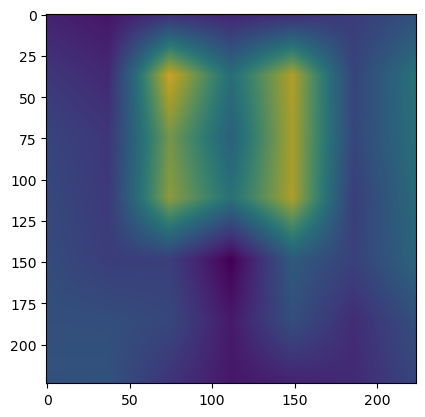

In [23]:
plt.imshow(np.mean(p[idx,:,:],axis=-1))
plt.imshow(k,alpha=0.7)
plt.show()

bacterial_leaf_blight


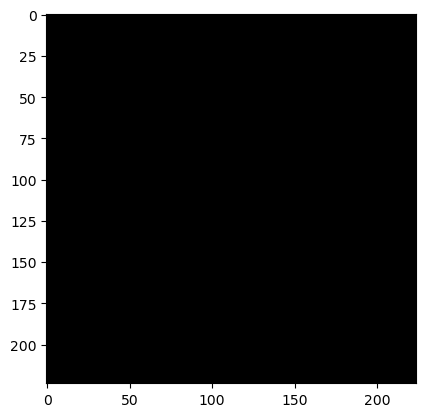

In [24]:
idx =6
features_for_img = o1[idx,:,:,:]
cat = tf.argmax(o2[idx]).numpy()
weights = model.layers[-1].get_weights()[0][:,cat]
image = sp.ndimage.zoom(features_for_img, (32,32,1), order=1)
k=np.dot(image[:,:,:],weights)
p=tf.keras.applications.mobilenet.preprocess_input(images)
dict1={0:'bacterial_leaf_blight',1:'Brown_Spot',2:'Healthy',3:'Hispa',4:'leaf_blast',5:'leaf_scald',6:'narrow_brown_spot',7:'Shath Blight',8:'Tungro'}
print(dict1[cat])
plt.imshow(images[idx,:,:,:])
plt.show()

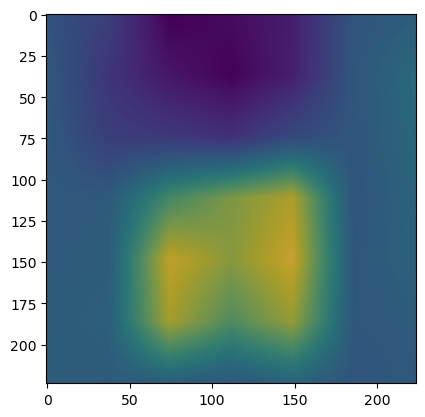

In [25]:
plt.imshow(np.mean(p[idx,:,:],axis=-1))
plt.imshow(k,alpha=0.7)
plt.show()

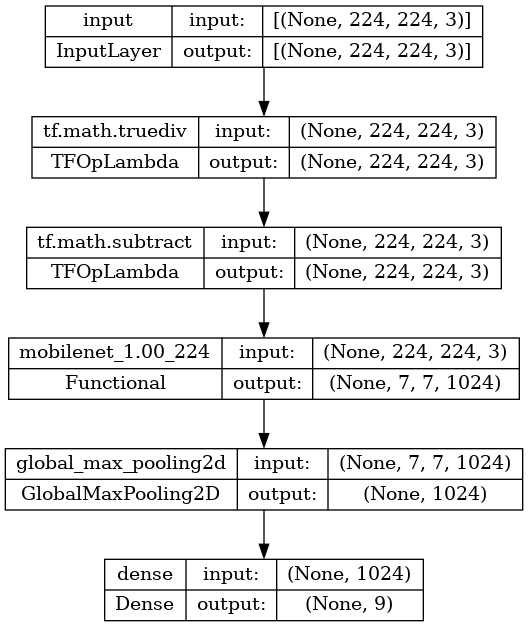

In [26]:
from keras.utils.vis_utils import plot_model
plot_model(conv_model, to_file='model.png', show_shapes=True)